In [56]:
import imageio
from PIL import Image, ImageDraw, ImageFont
import matplotlib

In [13]:
import torch
import numpy as np
from torchvision import datasets
import tqdm

# Step 1: Test Forward Diffusion Process

Test the forward noising process q(x_t|x_0)

In [14]:
from ddpm_forward import ForwardDiffusion
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

forward_diffusion = ForwardDiffusion(
    timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    device=device
)

Using device: cuda


In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

print(f"Dataset loaded: {len(dataset)} images")

Dataset loaded: 60000 images


# Forward Noising Grid: 6 Samples Every 150 Steps

Show 6 clean digits and their progressive noising at 150-step intervals

In [16]:
# Get 6 different MNIST images
n_samples_forward = 6
forward_images = torch.stack([dataset[i][0] for i in range(n_samples_forward)]).to(device)

# Define timesteps to show (every 150 steps)
forward_timestep_interval = 150
forward_timesteps = list(range(0, 1000, forward_timestep_interval))

# Store noised images at each timestep
forward_noised_images = {}

for t_val in forward_timesteps:
    if t_val == 0:
        forward_noised_images[t_val] = forward_images.clone().cpu()
    else:
        t = torch.tensor([t_val] * n_samples_forward).to(device)
        noised = forward_diffusion.q_sample(forward_images, t)
        forward_noised_images[t_val] = noised.cpu()

print(f"Created noised versions at timesteps: {forward_timesteps}")

Created noised versions at timesteps: [0, 150, 300, 450, 600, 750, 900]


In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

In [18]:
# Visualize the forward noising grid
n_rows_forward = len(forward_timesteps)
n_cols_forward = n_samples_forward

fig, axes = plt.subplots(n_rows_forward, n_cols_forward, figsize=(n_cols_forward * 2, n_rows_forward * 2))

for row_idx, t_val in enumerate(forward_timesteps):
    for col_idx in range(n_samples_forward):
        img = forward_noised_images[t_val][col_idx].squeeze().numpy()
        axes[row_idx, col_idx].imshow(img, cmap='gray')
        axes[row_idx, col_idx].axis('off')
        
        # Add timestep label on the left
        if col_idx == 0:
            axes[row_idx, col_idx].text(-0.1, 0.5, f't={t_val}', 
                                        transform=axes[row_idx, col_idx].transAxes,
                                        fontsize=12, fontweight='bold',
                                        va='center', ha='right')

plt.suptitle(f'Forward Noising Process: {n_samples_forward} Samples Every {forward_timestep_interval} Steps', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

/tmp/ipykernel_4913/3477328698.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Generate Forward Process GIF

Create an animated GIF showing the forward noising process with all timesteps

In [19]:
# Generate forward process GIF with all timesteps
print("Generating forward process GIF...")

# Use one sample image
sample_img = forward_images[0:1]  # First image only

# Create frames for every timestep (or every few timesteps for smooth animation)
frames = []
timesteps_for_gif = list(range(0, 1000, 4))  # Every 4 steps for ~250 frames, ~5 seconds at 50fps

for t_val in tqdm.tqdm(timesteps_for_gif, desc="Creating forward frames"):
    # Get noised version
    if t_val == 0:
        noised_img = sample_img.clone().cpu()
    else:
        t = torch.tensor([t_val]).to(device)
        noised_img = forward_diffusion.q_sample(sample_img, t).cpu()
    
    # Convert to numpy and denormalize
    img_array = noised_img.squeeze().numpy()
    img_array = (img_array + 1) / 2  # From [-1, 1] to [0, 1]
    img_array = (img_array * 255).astype(np.uint8)
    
    # Create PIL image and resize for better visibility
    pil_img = Image.fromarray(img_array, mode='L')
    pil_img = pil_img.resize((280, 280), Image.NEAREST)  # 10x larger
    
    # Add text showing timestep
    pil_img = pil_img.convert('RGB')
    draw = ImageDraw.Draw(pil_img)
    text = f"Forward Step: {t_val}/999"
    
    # Draw text with background for visibility
    bbox = draw.textbbox((0, 0), text)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    draw.rectangle([(10, 10), (text_width + 20, text_height + 20)], fill='black')
    draw.text((15, 15), text, fill='white')
    
    frames.append(np.array(pil_img))

# Create duration list: first frame 1 second, rest at 50fps (0.02s per frame)
durations = [1000] + [20] * (len(frames) - 1)  # durations in milliseconds

# Save as GIF with custom durations
imageio.mimsave('forward.gif', frames, duration=durations, loop=0)
print(f"Forward GIF saved! First frame: 1s, then {len(frames)-1} frames at 50 fps = ~{1 + (len(frames)-1)/50:.1f} seconds total")

Generating forward process GIF...


Creating forward frames: 100%|██████████| 250/250 [00:00<00:00, 888.29it/s]


Forward GIF saved! First frame: 1s, then 249 frames at 50 fps = ~6.0 seconds total


# Step 2: create U-Net Model

create the U-Net architecture that will predict noise ε_θ(x_t, t)

In [20]:
from unet_model import create_model

# Create the U-Net model
model = create_model(
    device=device,
    base_channels=64
)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Step 3: Train the Model

Train the U-Net to predict noise using the simple loss function

In [21]:
from train_ddpm import train_epoch, p_sample, p_sample_loop, visualize_trajectory, visualize_samples
from torch.utils.data import DataLoader
import torch.optim as optim

EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 2e-4

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
model.train()
losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    avg_loss = train_epoch(model, train_loader, optimizer, forward_diffusion, device)
    losses.append(avg_loss)
    print(f"Average Loss: {avg_loss:.4f}")


Epoch 1/20


Training: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s, loss=0.0339]


Average Loss: 0.0582

Epoch 2/20


Training: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s, loss=0.0267]


Average Loss: 0.0343

Epoch 3/20


Training: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s, loss=0.0209]


Average Loss: 0.0308

Epoch 4/20


Training: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s, loss=0.0340]


Average Loss: 0.0292

Epoch 5/20


Training: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s, loss=0.0296]


Average Loss: 0.0278

Epoch 6/20


Training: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s, loss=0.0261]


Average Loss: 0.0269

Epoch 7/20


Training: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s, loss=0.0218]


Average Loss: 0.0262

Epoch 8/20


Training: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s, loss=0.0232]


Average Loss: 0.0258

Epoch 9/20


Training: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s, loss=0.0292]


Average Loss: 0.0258

Epoch 10/20


Training: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s, loss=0.0276]


Average Loss: 0.0251

Epoch 11/20


Training: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s, loss=0.0412]


Average Loss: 0.0250

Epoch 12/20


Training: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s, loss=0.0188]


Average Loss: 0.0249

Epoch 13/20


Training: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s, loss=0.0253]


Average Loss: 0.0244

Epoch 14/20


Training: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s, loss=0.0196]


Average Loss: 0.0243

Epoch 15/20


Training: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s, loss=0.0235]


Average Loss: 0.0239

Epoch 16/20


Training: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s, loss=0.0223]


Average Loss: 0.0244

Epoch 17/20


Training: 100%|██████████| 469/469 [00:19<00:00, 23.46it/s, loss=0.0225]


Average Loss: 0.0236

Epoch 18/20


Training: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s, loss=0.0227]


Average Loss: 0.0240

Epoch 19/20


Training: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s, loss=0.0229]


Average Loss: 0.0236

Epoch 20/20


Training: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s, loss=0.0235]

Average Loss: 0.0239


In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

/tmp/ipykernel_4913/223755458.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [24]:
# Sauvegarder le modèle entraîné
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses,
}, 'ddpm_model.pth')
print("Modèle sauvegardé dans 'ddpm_model.pth'")

Modèle sauvegardé dans 'ddpm_model.pth'


# Denoising Grid: 6 Samples Every 150 Steps

In [25]:
import tqdm
# Generate 6 noise samples and denoise them step by step (every 150 timesteps)
model.eval()

n_samples = 6
timestep_interval = 200

# Start with pure noise
x = torch.randn(n_samples, 1, 28, 28).to(device)

# Store images at each interval
timesteps_to_save = list(range(999, -1, -timestep_interval)) + [0]
timesteps_to_save = sorted(set(timesteps_to_save), reverse=True)  # Remove duplicates and sort

saved_images = {t: None for t in timesteps_to_save}
saved_images[999] = x.clone().cpu()

# Denoise step by step
print(f"Denoising {n_samples} samples, saving every {timestep_interval} steps...")
current_x = x.clone()

for t_val in tqdm.tqdm(reversed(range(1000)), desc="Denoising", total=1000):
    t = torch.full((n_samples,), t_val, device=device, dtype=torch.long)
    current_x = p_sample(model, current_x, t, forward_diffusion)
    
    if t_val in timesteps_to_save:
        saved_images[t_val] = current_x.clone().cpu()

# Final result
saved_images[0] = current_x.clone().cpu()

print(f"Saved images at timesteps: {timesteps_to_save}")

Denoising 6 samples, saving every 200 steps...


Denoising: 100%|██████████| 1000/1000 [00:01<00:00, 620.25it/s]

Saved images at timesteps: [999, 799, 599, 399, 199, 0]


In [26]:
# Visualize the denoising grid
n_rows = len(timesteps_to_save)
n_cols = n_samples

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for row_idx, t_val in enumerate(timesteps_to_save):
    for col_idx in range(n_samples):
        img = saved_images[t_val][col_idx].squeeze().numpy()
        axes[row_idx, col_idx].imshow(img, cmap='gray')
        axes[row_idx, col_idx].axis('off')
        
        # Add timestep label on the left
        if col_idx == 0:
            axes[row_idx, col_idx].text(-0.1, 0.5, f't={t_val}', 
                                        transform=axes[row_idx, col_idx].transAxes,
                                        fontsize=12, fontweight='bold',
                                        va='center', ha='right')

plt.suptitle(f'Denoising Process: {n_samples} Samples Every {timestep_interval} Steps', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


/tmp/ipykernel_4913/190345305.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [27]:
# Generate reverse process GIF with all timesteps
print("Generating reverse process GIF...")

model.eval()

# Start with pure noise
x_reverse = torch.randn(1, 1, 28, 28).to(device)

# Create frames for every timestep
frames_reverse = []
timesteps_for_reverse_gif = list(range(999, -1, -4))  # Every 4 steps backwards, ~250 frames

# Store initial noise
img_array = x_reverse.clone().cpu().squeeze().numpy()
img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize
img_array = (img_array * 255).astype(np.uint8)
pil_img = Image.fromarray(img_array, mode='L')
pil_img = pil_img.resize((280, 280), Image.NEAREST)
pil_img = pil_img.convert('RGB')
draw = ImageDraw.Draw(pil_img)
text = f"Reverse Step: 999/999"
bbox = draw.textbbox((0, 0), text)
text_width = bbox[2] - bbox[0]
text_height = bbox[3] - bbox[1]
draw.rectangle([(10, 10), (text_width + 20, text_height + 20)], fill='black')
draw.text((15, 15), text, fill='white')
frames_reverse.append(np.array(pil_img))

# Denoise step by step, saving every 4 steps
for t_val in tqdm.tqdm(reversed(range(1000)), desc="Creating reverse frames"):
    t = torch.full((1,), t_val, device=device, dtype=torch.long)
    x_reverse = p_sample(model, x_reverse, t, forward_diffusion)
    
    # Save frame every 4 steps
    if t_val % 4 == 0 or t_val == 0:
        # Convert to numpy and normalize for display
        img_array = x_reverse.clone().cpu().squeeze().numpy()
        img_array = (img_array + 1) / 2  # From [-1, 1] to [0, 1]
        img_array = np.clip(img_array, 0, 1)
        img_array = (img_array * 255).astype(np.uint8)
        
        # Create PIL image and resize
        pil_img = Image.fromarray(img_array, mode='L')
        pil_img = pil_img.resize((280, 280), Image.NEAREST)
        
        # Add text showing timestep
        pil_img = pil_img.convert('RGB')
        draw = ImageDraw.Draw(pil_img)
        text = f"Reverse Step: {t_val}/999"
        
        # Draw text with background
        bbox = draw.textbbox((0, 0), text)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        draw.rectangle([(10, 10), (text_width + 20, text_height + 20)], fill='black')
        draw.text((15, 15), text, fill='white')
        
        frames_reverse.append(np.array(pil_img))

# Create duration list: all frames at 50fps except last frame (1 second)
durations_reverse = [20] * (len(frames_reverse) - 1) + [1000]  # durations in milliseconds

# Save as GIF with custom durations
imageio.mimsave('denoising.gif', frames_reverse, duration=durations_reverse, loop=0)
print(f"Reverse GIF saved! {len(frames_reverse)-1} frames at 50 fps, then last frame: 1s = ~{(len(frames_reverse)-1)/50 + 1:.1f} seconds total")

Generating reverse process GIF...


Creating reverse frames: 1000it [00:01, 547.69it/s]


Reverse GIF saved! 250 frames at 50 fps, then last frame: 1s = ~6.0 seconds total


# Generate Reverse Process GIF

Create an animated GIF showing the reverse denoising process with all timesteps

# Step 4: Evaluation

In [51]:
from evaluation import train_classifier, evaluate_generated_samples, compare_with_real_data

classifier = train_classifier(device=device, epochs=5)

Training classifier on real MNIST data...


Epoch 1/5: 100%|██████████| 469/469 [00:04<00:00, 110.01it/s, loss=0.1292, acc=89.87%]


Epoch 1 - Train Accuracy: 89.87%


Epoch 2/5: 100%|██████████| 469/469 [00:04<00:00, 109.10it/s, loss=0.0730, acc=96.92%]


Epoch 2 - Train Accuracy: 96.92%


Epoch 3/5: 100%|██████████| 469/469 [00:04<00:00, 111.14it/s, loss=0.0443, acc=97.61%]


Epoch 3 - Train Accuracy: 97.61%


Epoch 4/5: 100%|██████████| 469/469 [00:04<00:00, 111.54it/s, loss=0.0435, acc=98.07%]


Epoch 4 - Train Accuracy: 98.07%


Epoch 5/5: 100%|██████████| 469/469 [00:04<00:00, 106.41it/s, loss=0.0565, acc=98.35%]


Epoch 5 - Train Accuracy: 98.35%

Classifier Test Accuracy: 98.90%
Saved classifier to 'mnist_classifier.pth'


In [52]:
model.eval()
generated_for_eval = p_sample_loop(
    model,
    shape=(1000, 1, 28, 28),
    forward_diffusion=forward_diffusion,
    save_trajectory=False
)

print(f"Generated {generated_for_eval.shape[0]} samples")

Sampling: 100%|██████████| 1000/1000 [01:58<00:00,  8.45it/s]

Generated 1000 samples


In [49]:
results = evaluate_generated_samples(
    generated_images=generated_for_eval,
    classifier=classifier,
    device=device
)


EVALUATION RESULTS

1. Average Confidence Score: 0.9408
   (Higher is better, >0.90 is excellent)

2. High Confidence Ratio (>0.9): 0.8210
   (82.1% of samples)

3. Class Distribution:
   Digit 0:  105 ( 10.5%) █████
   Digit 1:  150 ( 15.0%) ███████
   Digit 2:   55 (  5.5%) ██
   Digit 3:   98 (  9.8%) ████
   Digit 4:  126 ( 12.6%) ██████
   Digit 5:  104 ( 10.4%) █████
   Digit 6:  130 ( 13.0%) ██████
   Digit 7:   57 (  5.7%) ██
   Digit 8:   81 (  8.1%) ████
   Digit 9:   94 (  9.4%) ████

4. Distribution Uniformity: 0.7103
   (1.0 = perfect uniform distribution)

5. Overall Quality Score: 0.8240
   (Average of confidence, high-conf ratio, and uniformity)


In [45]:
baseline_confidence, baseline_confidences = compare_with_real_data(
    classifier=classifier,
    device=device,
    num_samples=1000
)



Evaluating real test data for comparison...

Real Data Metrics (Baseline):
  Accuracy: 0.9920
  Average Confidence: 0.9934


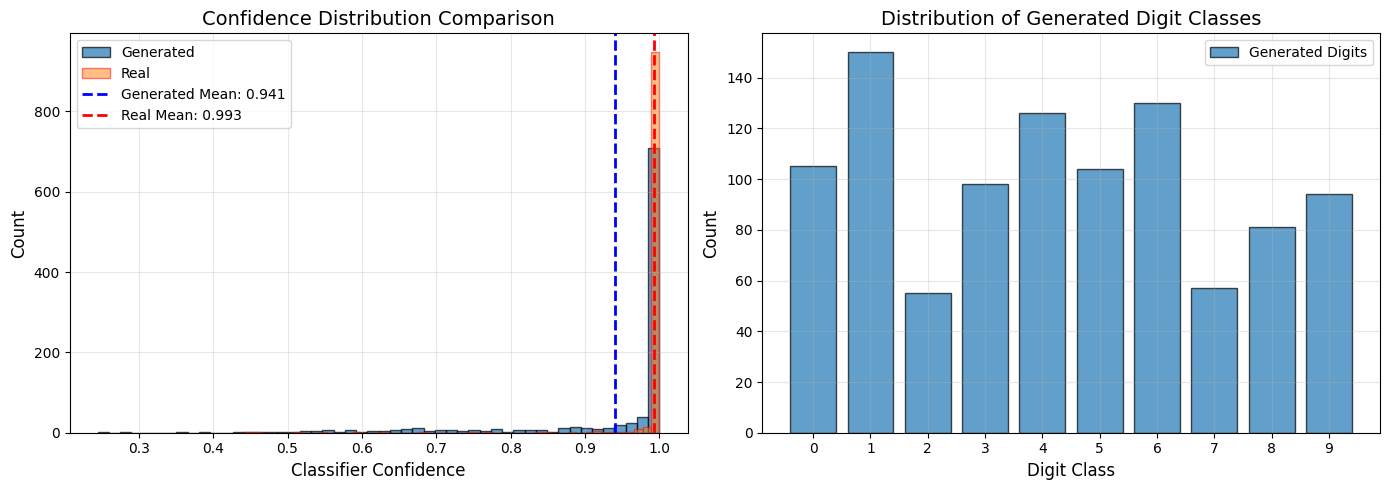

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confidence distribution
axes[0].hist(results['confidences'], bins=50, edgecolor='black', alpha=0.7, label='Generated')
axes[0].hist(baseline_confidences, bins=50, edgecolor='red', alpha=0.5, label='Real')
axes[0].axvline(results['avg_confidence'], color='blue', linestyle='--', linewidth=2, 
                label=f'Generated Mean: {results["avg_confidence"]:.3f}')
axes[0].axvline(baseline_confidence, color='red', linestyle='--', linewidth=2,
                label=f'Real Mean: {baseline_confidence:.3f}')
axes[0].set_xlabel('Classifier Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Confidence Distribution Comparison', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Class distribution
unique, counts = np.unique(results['predictions'], return_counts=True)
axes[1].bar(unique, counts, edgecolor='black', alpha=0.7, label='Generated Digits')
axes[1].set_xlabel('Digit Class', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of Generated Digit Classes', fontsize=14)
axes[1].set_xticks(range(10))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()